<a href="https://colab.research.google.com/github/kboroz/DeepFinance/blob/main/DeepHedging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from tensorflow.keras.backend import constant
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, InputSpec
from tensorflow.keras import initializers
from tensorflow.keras.constraints import max_norm
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

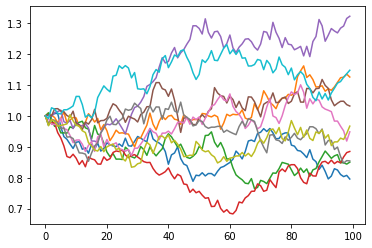

In [2]:
# Trajectories of the Black scholes model
# Let it run to initialize the following parameters, the trajectories 
# are not needed afterwards

N=100 # time disrectization
S0=1 # initial value of the asset
strike=1 # strike for the call option 
T=1.0 # maturity
sigma=0.2 # volatility in Black Scholes
R=10 # number of Trajectories

logS= np.zeros((N,R))
logS[0,]=np.log(S0)*np.ones((1,R))

for i in range(R):
    for j in range(N-1):
        increment = np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N))
        logS[j+1,i] =logS[j,i]+increment

S=np.exp(logS)

for i in range(R):
   plt.plot(S[:,i])
plt.show()

In [3]:
import scipy.stats as scipy
from scipy.stats import norm

#Blackscholes price

def BS(S0, strike, T, sigma):
    return S0*scipy.norm.cdf((np.log(S0/strike)+0.5*T*sigma**2)/(np.sqrt(T)*sigma))-strike*scipy.norm.cdf((np.log(S0/strike)-0.5*T*sigma**2)/(np.sqrt(T)*sigma))

priceBS=BS(S0,strike,T,sigma)
print('Price of a Call option in the Black scholes model with initial price', S0, 'strike', strike, 'maturity', T , 'and volatility' , sigma, 'is equal to', BS(S0,strike,T,sigma))


Price of a Call option in the Black scholes model with initial price 1 strike 1 maturity 1.0 and volatility 0.2 is equal to 0.07965567455405798


In [4]:
#Definition of neural networks for heding strategies

m = 1 # dimension of price
d = 2 # number of layers in strategy
n = 32  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]

In [5]:
#Implementing the loss function
# Inputs is the training set below, containing the price S0, 
#the initial hedging being 0, and the increments of the log price process 
price = Input(shape=(m,))
hedge = Input(shape=(m,))

inputs = [price]+[hedge]


for j in range(N):
    strategy = price
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the hedging strategy at j , i.e. the neural network g_j
    incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)# creating the price at time j+1
    priceincr=Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    #mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
    hedge = Add()([hedge,hedgenew]) # building up the discretized stochastic integral
    inputs = inputs + [incr]
    price=pricenew
payoff= Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike) - priceBS)(price) 
outputs = Subtract()([payoff,hedge]) # payoff minus priceBS minus hedge

inputs = inputs
outputs= outputs

model_hedge = Model(inputs=inputs, outputs=outputs)

In [6]:
model_hedge.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 add (Add)                      (None, 1)            0           ['lambda[0][0]',                 
                                                                  'input_3[0][0]']            

In [7]:
Ktrain = 2*10**4
initialprice = S0

# xtrain consists of the price S0, 
#the initial hedging being 0, and the increments of the log price process 
xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])

ytrain=np.zeros((Ktrain,1))

In [8]:


#sgd=optimizers.SGD(lr=0.0001)
#model_hedge.compile(optimizer=sgd,loss='mean_squared_error')
model_hedge.compile(optimizer='adam',loss='mean_squared_error')



In [9]:
import matplotlib.pyplot as plt

for i in range(50):
    model_hedge.fit(x=xtrain,y=ytrain, epochs=1,verbose=True)

#plt.hist(model_hedge.predict(xtrain))
#plt.show()
#print(np.mean(model_hedge.predict(xtrain)))

625/625 [==============================] - 17s 28ms/step - loss: 5.7211e-04


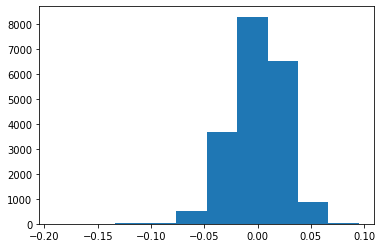

0.024466617
0.000115003706


In [10]:


Ltest = 10**4
        
xtest=([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [np.random.normal(-(sigma)**2*T/(2*N),(sigma)*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])
plt.hist(model_hedge.predict(xtest))
plt.show()
print(np.std(model_hedge.predict(xtest)))
print(np.mean(model_hedge.predict(xtest)))



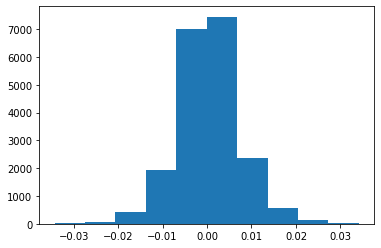

0.00694392838275752
0.00039349088458228847


In [11]:
logincrements = xtest[3:3+N]
hedge = np.zeros(Ktrain)
price = S0*np.ones((Ktrain,N))
for k in range(N-1):
    helper = logincrements[k][:,]
    helper = helper.transpose()
    price[:,k+1] = price[:,k]*np.exp(helper[:])
    hedge[:] = hedge[:] + scipy.norm.cdf((np.log(price[:,k]/strike)+0.5*(T-k*T/N)*sigma**2)/(np.sqrt(T-k*T/N)*sigma))*(price[:,k+1]-price[:,k])
hedge[:]= hedge[:]-0.5*(np.abs(price[:,N-1]-strike)+(price[:,N-1]-strike))+priceBS
plt.hist(hedge)
plt.show()
print(np.std(hedge))
print(np.mean(hedge))

In [12]:
weights = model_hedge.get_weights()
#print(weights)

In [13]:
#This works when the number of layers equals d=2

def deltastrategy(s,j):
    length=s.shape[0]
    g=np.zeros(length)
    for p in range(length):
        ghelper=np.tanh(s[p]*(weights[j*2*d])+weights[j*2*d+1])
        g[p]=np.sum(np.squeeze(weights[2*(d-1)+j*2*d])*np.squeeze(ghelper))
        g[p]=g[p]+weights[2*d-1+j*2*d]   
    return g

In [14]:


s=np.linspace(0.5,1.5,10)
k=10
y=deltastrategy(s,k)
z=scipy.norm.cdf((np.log(s/strike)+0.5*(T-k*T/N)*sigma**2)/(np.sqrt(T-k*T/N)*sigma))



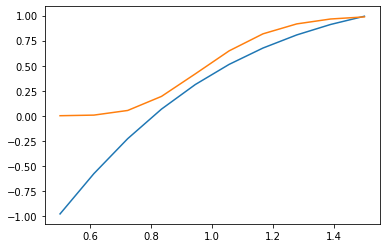

In [15]:
plt.plot(s,y,s,z)
plt.show()

In [16]:
#Definition of neural networks for heding strategies

m = 1 # dimension of price
d = 3 # number of layers in strategy
n = 8  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]

In [17]:
#Implementing the loss function
# Inputs is the training set below, containing the price S0, 
#the initial hedging being 0, and the increments of the log price process 
price = Input(shape=(m,))
hedge = Input(shape=(m,))
hedgeeval = Input(shape=(m,))
premium = Input(shape=(m,))

inputs = [price]+[hedge]+[hedgeeval]+[premium]
outputhelper=[]

premium = Dense(m, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                bias_initializer=initializers.RandomNormal(0,1))(premium)

for j in range(N):
    strategy = price
    strategyeval=hedgeeval
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the hedging strategy at j , i.e. the neural network g_j
        strategyeval=layers[k+(j)*d](strategyeval)
    incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)# creating the price at time j+1
    priceincr=Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    #mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
    hedge = Add()([hedge,hedgenew]) # building up the discretized stochastic integral
    inputs = inputs + [incr]
    outputhelper = outputhelper + [strategyeval]
    price=pricenew
payoff= Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike))(price) 
outputs = Subtract()([payoff,hedge]) 
outputs = Subtract()([outputs,premium]) # payoff minus price minus hedge 
outputs= [outputs] + outputhelper +[premium]
outputs = Concatenate()(outputs)

model_hedge_strat = Model(inputs=inputs, outputs=outputs)

In [18]:


Ktrain = 10**5
initialprice = S0

# xtrain consists of the price S0, 
#the initial hedging being 0, and the increments of the log price process 
xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [np.ones((Ktrain,m))] +
          [priceBS*np.ones((Ktrain,m))]+
          [np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])

ytrain=np.zeros((Ktrain,1+N))



In [19]:
#import keras
from keras import losses
def custom_loss(y_true,y_pred):
    #return losses.mean_squared_error(y_true[0], y_pred[0])
    z = y_pred[:,0]-y_true[:,0]
    z=K.mean(K.square(z))
    return z

In [20]:
model_hedge_strat.compile(optimizer='adam',loss=custom_loss)

3125/3125 [==============================] - 177s 57ms/step - loss: 1.8339e-04


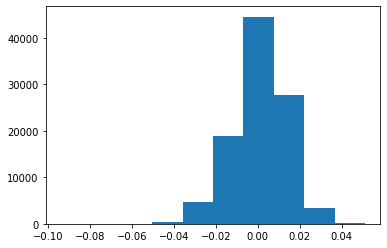

0.01275269
0.07849496


In [21]:
import matplotlib.pyplot as plt

for i in range(5):
    model_hedge_strat.fit(x=xtrain,y=ytrain, epochs=1,verbose=True)
plt.hist(model_hedge_strat.predict(xtrain)[:,0])
plt.show()
print(np.std(model_hedge_strat.predict(xtrain)[:,0]))
print(np.mean(model_hedge_strat.predict(xtrain)[:,N+1]))

In [22]:
Ktest=10
xtest = ([initialprice*np.ones((Ktest,m))] +
          [np.zeros((Ktest,m))]+
          [np.linspace(0.5,1.5,Ktest)] +#change this if you go to higher dimensions
          [priceBS*np.ones((Ktest,m))]+
          [np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N),(Ktest,m)) for i in range(N)])

y=model_hedge_strat.predict(xtest)[:,10]
print(y)

[-0.47426006 -0.27174786 -0.04038572  0.2053693   0.4455629   0.6620724
  0.84489244  0.9926775   1.1093439   1.2005877 ]


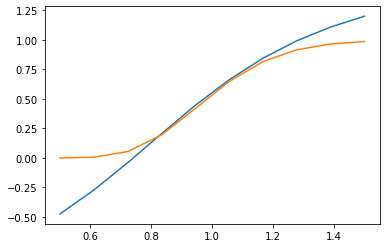

In [23]:


l = 9
s=np.linspace(0.5,1.5,Ktest)
z=scipy.norm.cdf((np.log(s/strike)+0.5*(T-l*T/N)*sigma**2)/(np.sqrt(T-l*T/N)*sigma))
#plt.plot(s,z)
#plt.plot(s,y)
plt.plot(s,y,s,z)
plt.show()



In [24]:
#Definition of neural networks for heding strategies

m = 1 # dimension of price
d = 3 # number of layers in strategy
n = 8  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]

In [25]:
#Implementing the loss function
# Inputs is the training set below, containing the price S0, 
#the initial hedging being 0, and the increments of the log price process 
price = Input(shape=(m,))
hedge = Input(shape=(m,))
hedgeeval = Input(shape=(m,))
premium = Input(shape=(m,))

inputs = [price]+[hedge]+[hedgeeval]+[premium]
outputhelper=[]

premium = Dense(m, activation='linear', trainable=False,
                kernel_initializer=initializers.RandomNormal(1.0,0.0),#kernel_initializer='random_normal',
                bias_initializer=initializers.RandomNormal(0.0,0.0))(premium)

for j in range(N):
    strategy = Concatenate()([price,premium])
    strategyeval=Concatenate()([hedgeeval,premium])
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the hedging strategy at j , i.e. the neural network g_j
        strategyeval=layers[k+(j)*d](strategyeval)
    incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)# creating the price at time j+1
    priceincr=Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    #mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
    hedge = Add()([hedge,hedgenew]) # building up the discretized stochastic integral
    inputs = inputs + [incr]
    outputhelper = outputhelper + [strategyeval]
    price=pricenew
payoff= Lambda(lambda x : 0.5*(K.abs(x-strike)+x-strike))(price) 
outputs = Subtract()([payoff,hedge]) 
outputs = Subtract()([outputs,premium]) # payoff minus price minus hedge 
outputs= [outputs] + outputhelper +[premium]
outputs = Concatenate()(outputs)

model_hedge_strat = Model(inputs=inputs, outputs=outputs)


In [26]:
Ktrain = 10**5
initialprice = S0

# xtrain consists of the price S0, 
#the initial hedging being 0, and the increments of the log price process 
xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [np.zeros((Ktrain,m))]+
          [np.ones((Ktrain,m))] +
          [priceBS*np.linspace(0.5,1.5,Ktrain)]+
          [np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)])

ytrain=np.zeros((Ktrain,1+N))

In [27]:
#import keras
from keras import losses
def custom_loss(y_true,y_pred):
    #return losses.mean_squared_error(y_true[0], y_pred[0])
    z = y_pred[:,0]-y_true[:,0]
    z=K.mean(K.exp(-z))
    return z


In [28]:
model_hedge_strat.compile(optimizer='adam',loss=custom_loss)

3125/3125 [==============================] - 176s 56ms/step - loss: 1.0020


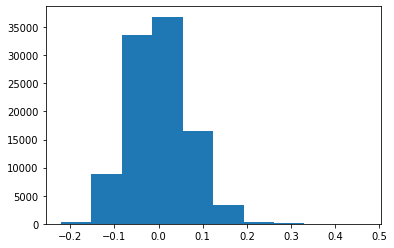

0.06569089
0.07965567


In [29]:


import matplotlib.pyplot as plt

for i in range(5):
    model_hedge_strat.fit(x=xtrain,y=ytrain, epochs=1,verbose=True)
plt.hist(model_hedge_strat.predict(xtrain)[:,0])
plt.show()
print(np.std(model_hedge_strat.predict(xtrain)[:,0]))
print(np.mean(model_hedge_strat.predict(xtrain)[:,N+1]))



In [30]:


Ktest = 10**5
for x in np.linspace(0.98,1.0,10):
    xtest = ([initialprice*np.ones((Ktest,m))] +
              [np.zeros((Ktest,m))]+
              [np.linspace(0.5,1.5,Ktest)] +#change this if you go to higher dimensions
              [priceBS*x*np.ones((Ktest,m))]+
              [np.random.normal(-(sigma)**2*T/(2*N),sigma*np.sqrt(T)/np.sqrt(N),(Ktest,m)) for i in range(N)])
    y=np.mean(np.exp(-model_hedge_strat.predict(xtest)[:,0]))
    print(y)



0.9999493
1.0005391
1.0005609
1.0004578
1.0010014
1.0010941
1.0011731
1.001597
1.0018468
1.0020854
